In [1]:
import os
import sys
import datetime
import requests
from io import BytesIO
from zipfile import ZipFile
import json
from datetime import datetime

import ee
import pystac
from pystac.extensions.eo import EOExtension
from pystac.extensions.eo import Band
import geopandas as gpd
import rasterio
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath('../src/data'))
from fetch import nlcd_from_mrlc, landtrendr_from_gee, colorize_nlcd, dem_from_tnm
from gee_utils import download_gflandsat_img, get_gflandsat_url

In [3]:
# Define functions to fetch the data.
def read_gee_url(url):
    """Given a download URL generated by Google Earth Engine, downloads 
    and opens the raster into memory.
    Parameters
    ----------
    url : str
      URL from which the raster will be downloaded, generated by Google Earth
      Engine.
    Returns
    -------
    raster : arr
      raster read into an array
    profile : dict
      raster metadata
    """
    response = requests.get(url)
    zip = ZipFile(BytesIO(response.content))
    img_name = zip.namelist()[0]
    img_data = zip.read(img_name)

    # Open raster into memory.
    with MemoryFile(img_data) as memfile:
        with memfile.open() as src:
            raster = src.read()
            profile = src.profile
            
    return raster, profile

def get_image_url(img_name, bounds, epsg=4326, scale=30, cog=True):
    """
    Get image url from Google Earth Engine (GEE) using a bounding box.

    Parameters
    ----------
    img_name : str
        Image name from the GEE collection.
    bounds : list
        Bounding box in the form [xmin, ymin, xmax, ymax].

    Returns
    -------
    url : str
        URL from which the raster will be downloaded, generated by Google Earth Engine.
    metadata : dict
        Image metadata.
    """
    img = ee.Image(img_name)
    bbox = ee.Geometry.BBox(*bounds)
    url_params = dict(filePerBand=False,
                      scale=scale,
                      crs=f'EPSG:{epsg}',
                      formatOptions={'cloudOptimized':cog})

    url = img.clip(bbox).getDownloadURL(url_params)

    return url, img.getInfo()

In [4]:
# Load the USGS QQ shapefile for Oregon state.
qq_shp = gpd.read_file('../data/external/oregon_quarter_quads.shp').to_crs('epsg:4326')

# Select only 5 qq cells to play with.
qq_shp = qq_shp[qq_shp.CELL_ID.isin(qq_shp.head().CELL_ID)]

# Initialize the Earth Engine module.
# You need to setup your Google Earth Engine API key before running this cell.
ee.Initialize()

gfl = ee.ImageCollection('projects/KalmanGFwork/GFLandsat_V1')\
        .filterDate('2019-01-01', '2019-12-31')
metadata = gfl.getInfo()

# List all image names in the collection.
img_names = [i['id'] for i in metadata['features']]

# Pick the image closest to the date of the NAIP and LIDAR acquisitions.
# NotImplemented
img_name = img_names[0]

# List band names in the first image.
bands = [i['id'] for i in metadata['features'][0]['bands']]

In [5]:
count = 0
for index, row in qq_shp.iterrows():
    feature = row.geometry
    lntr = landtrendr_from_gee(feature.bounds, year=2019, epsg=4326)
    nlcd = nlcd_from_mrlc(feature.bounds, layer='NLCD_2019_Land_Cover_L48', width=233, height=233, inSR=4326)
    dem = dem_from_tnm(feature.bounds, width=233, height=233, inSR=4326)
    qq_clip, qq_info = get_image_url(img_name, feature.bounds)
    gfl, gfl_profile = read_gee_url(qq_clip)
    count += 1
    if count > 1:
        break

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /vsimem/93fa294c-06e4-485f-8da1-3cb15c1f5d5d/93fa294c-06e4-485f-8da1-3cb15c1f5d5d.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /vsimem/78d586f0-4832-460c-b543-148468bb8d33/78d586f0-4832-460c-b543-148468bb8d33.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channel

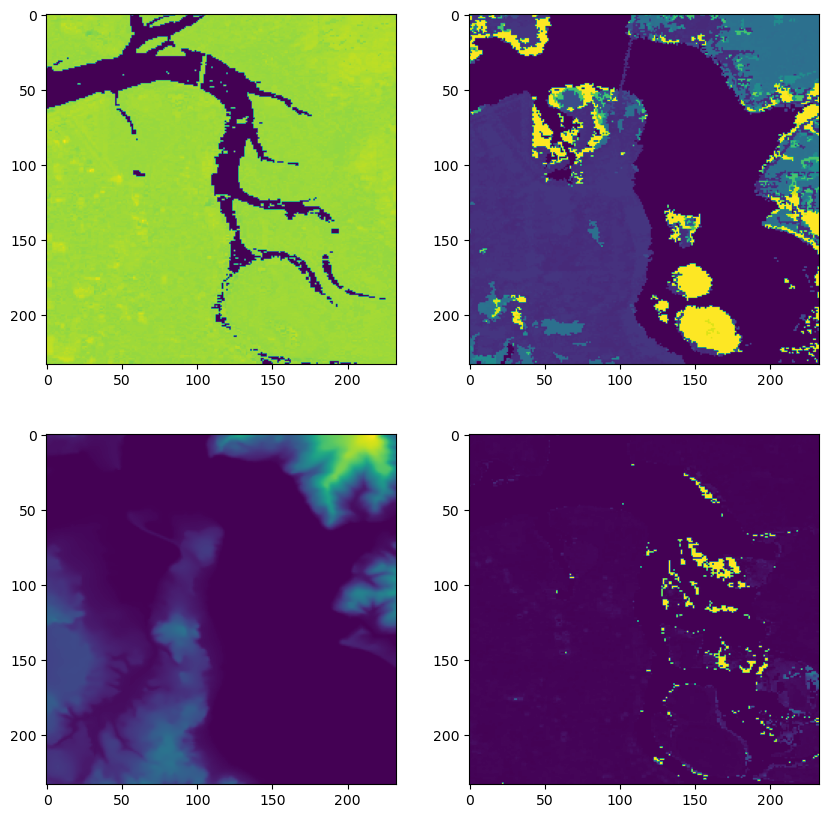

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221)
plt.imshow(lntr[0][1])
ax = fig.add_subplot(222)
plt.imshow(nlcd)
ax = fig.add_subplot(223)
plt.imshow(dem)
ax = fig.add_subplot(224)
plt.imshow(gfl[1])

In [7]:
img_name

'projects/KalmanGFwork/GFLandsat_V1/Gap_Filled_Landsat_CONUS_month_10_2019_v2'